In [3]:
import pandas as pd
import glob
import os

# List directories containing the Excel files
directories = [
    r"C:\project_data\results\lower_bound\IMDB-BINARY",
    r"C:\project_data\results\lower_bound\PROTEINS",
    r"C:\project_data\results\lower_bound\AIDS"
]

# Collect all Excel file paths from directories
all_files = []
for directory in directories:
    files = glob.glob(os.path.join(directory, "*.xlsx"))
    all_files.extend(files)

# Read each Excel file and combine them into one DataFrame
df_list = []
for file in all_files:
    temp_df = pd.read_excel(file)
    df_list.append(temp_df)
df = pd.concat(df_list, ignore_index=True)

# Filter to only use datasets AIDS and IMDB-BINARY
datasets = ["AIDS", "IMDB-BINARY", "PROTEINS"]
df = df[df["Dataset"].isin(datasets)]

# Compute total pairs per dataset (used for calculating percentages)
total_pairs = df.groupby("Dataset").size()

def create_pivot_table(threshold):
    # Filter for skipped pairs above the given threshold
    skipped_df = df[df["Lower Bound"] > threshold]

    # Create a pivot table with count of skipped pairs for each heuristic and dataset
    pivot_count = pd.pivot_table(
        skipped_df,
        index="Heuristic",
        columns="Dataset",
        aggfunc='size',
        fill_value=0
    )

    # Ensure both datasets exist in the pivot columns (if one is missing add it)
    for ds in datasets:
        if ds not in pivot_count.columns:
            pivot_count[ds] = 0

    # Order the columns (AIDS, IMDB-BINARY)
    pivot_count = pivot_count[datasets]

    # Create a copy for percentages
    pivot_pct = pivot_count.copy().astype(float)
    #for ds in datasets:
        #pivot_pct[ds] = (pivot_pct[ds] / total_pairs[ds]) * 100

    # Add a new column with Total Skipped (absolute count, not percentage)
    pivot_pct["Total Skipped"] = pivot_count.sum(axis=1)
    return pivot_count


In [4]:
# Create the second pivot table for threshold 50
pivot_table_50 = create_pivot_table(50)
print("\nPivot table with threshold 50 (percentages with absolute 'Total Skipped'):")
print(pivot_table_50)


Pivot table with threshold 50 (percentages with absolute 'Total Skipped'):
Dataset                                        AIDS  IMDB-BINARY  PROTEINS
Heuristic                                                                 
Combined Basic (Node+Edge Count Difference)  323890       211515    341544
Degree Distribution Difference                    0         1327     48881
Edge Count Difference                        116884       187449    253809
Edge Overlap Difference                      262831       425243    506926
Node Count Difference                         69711         5201    130507
Node Label Mismatch                               2            0     47900


In [5]:
import os
import xml.etree.ElementTree as ET

def compute_graph_size(gxl_path):
    """
    Parses a GXL file and calculates its size as a tuple.
    The size is defined by the number of unique nodes and edges.
    """
    try:
        tree = ET.parse(gxl_path)
        root = tree.getroot()
    except Exception as e:
        print(f"Error parsing {gxl_path}: {e}")
        return (0, 0)

    graph_elem = root.find('graph')
    if graph_elem is None:
        print(f"No graph element found in {gxl_path}")
        return (0, 0)

    # Using node 'id' attributes to ensure uniqueness
    node_ids = {node.get("id") for node in graph_elem.findall('node')}
    # For edges, simply count unique edge elements (could be modified if edges need further uniqueness criteria)
    edge_ids = set()
    for edge in graph_elem.findall('edge'):
        # Create a tuple of sorted 'from' and 'to' attributes for undirected uniqueness if available.
        src = edge.get("from")
        tgt = edge.get("to")
        if src is not None and tgt is not None:
            edge_ids.add(tuple(sorted((src, tgt))))
        else:
            edge_ids.add(edge)

    num_nodes = len(node_ids)
    num_edges = len(edge_ids)
    return num_nodes + num_edges

def compute_pair_size(graph_id_1, graph_id_2, gxl_directory):
    """
    Given the ids of two graphs and the directory where the GXL files are stored,
    this function loads `graph_id_1.gxl` and `graph_id_2.gxl`, computes each individual
    size (number of unique nodes and edges), and returns their mean as a tuple.
    """
    path1 = os.path.join(gxl_directory, f"{graph_id_1}.gxl")
    path2 = os.path.join(gxl_directory, f"{graph_id_2}.gxl")

    size1 = compute_graph_size(path1)
    size2 = compute_graph_size(path2)

    return (size1 + size2) / 2.0

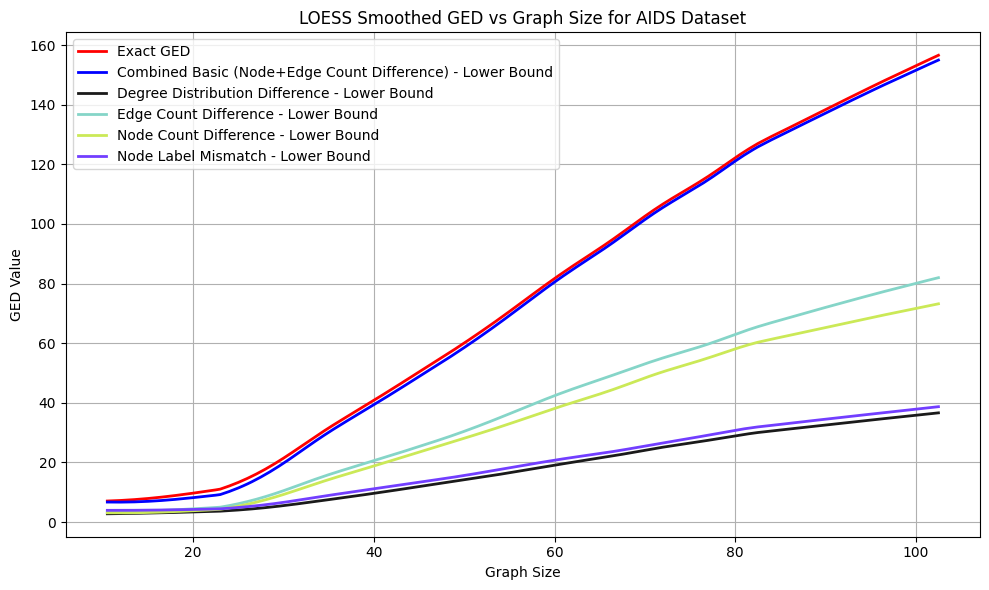

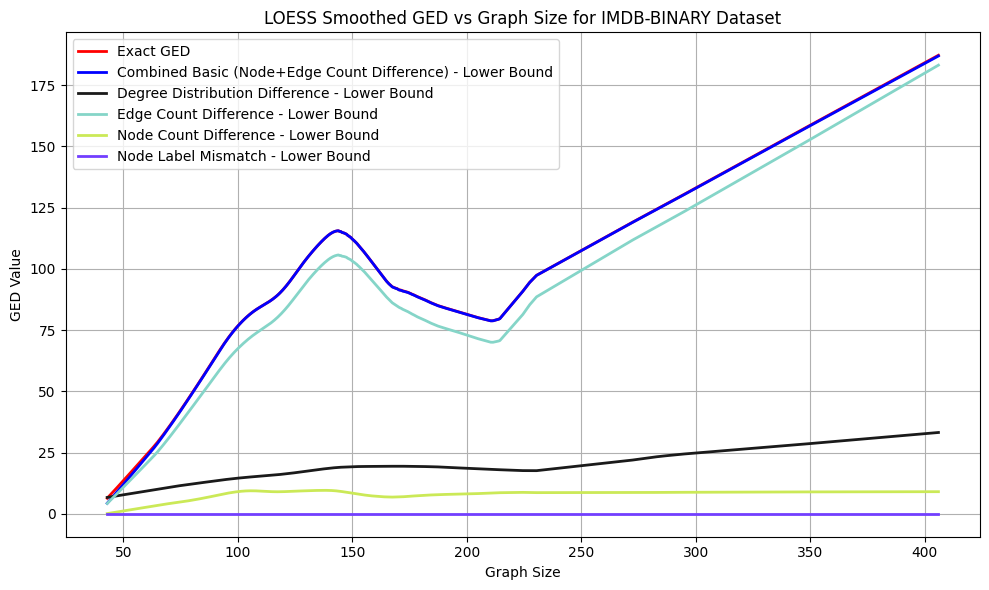

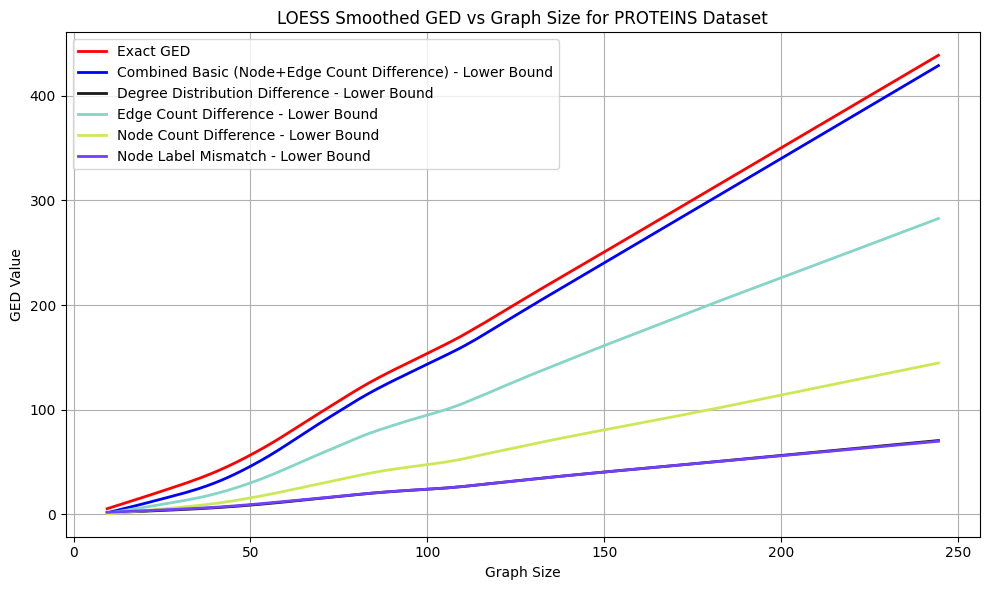

In [8]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess
import xml.etree.ElementTree as ET

# Helper functions to compute graph sizes
def compute_graph_size(gxl_path):
    """
    Parses a GXL file and calculates its size as the sum of unique nodes and edges.
    """
    try:
        tree = ET.parse(gxl_path)
        root = tree.getroot()
    except Exception as e:
        print(f"Error parsing {gxl_path}: {e}")
        return 0
    graph_elem = root.find('graph')
    if graph_elem is None:
        print(f"No graph element found in {gxl_path}")
        return 0
    # Use node 'id' attributes for uniqueness
    node_ids = {node.get("id") for node in graph_elem.findall('node')}
    # Determine edge uniqueness (using sorted 'from' and 'to')
    edge_ids = set()
    for edge in graph_elem.findall('edge'):
        src = edge.get("from")
        tgt = edge.get("to")
        if src is not None and tgt is not None:
            edge_ids.add(tuple(sorted((src, tgt))))
        else:
            edge_ids.add(edge)
    return len(node_ids) + len(edge_ids)

def compute_pair_size(graph_id1, graph_id2, gxl_directory):
    """
    Calculates the mean graph size for the two graphs given their ids.
    """
    path1 = os.path.join(gxl_directory, f"{graph_id1}.gxl")
    path2 = os.path.join(gxl_directory, f"{graph_id2}.gxl")
    size1 = compute_graph_size(path1)
    size2 = compute_graph_size(path2)
    return (size1 + size2) / 2.0

# --- Load lower bound data for all datasets ---
lower_bound_dirs = [
    r"C:\project_data\results\lower_bound\IMDB-BINARY",
    r"C:\project_data\results\lower_bound\PROTEINS",
    r"C:\project_data\results\lower_bound\AIDS"
]

all_lb_files = []
for directory in lower_bound_dirs:
    files = glob.glob(os.path.join(directory, "*.xlsx"))
    all_lb_files.extend(files)

df_list = []
for file in all_lb_files:
    temp_df = pd.read_excel(file)
    df_list.append(temp_df)
df_lower = pd.concat(df_list, ignore_index=True)
datasets_list = ["AIDS", "IMDB-BINARY", "PROTEINS"]
df_lower = df_lower[df_lower["Dataset"].isin(datasets_list)]

# Filter out Edge Overlap Difference heuristic
df_lower = df_lower[df_lower["Heuristic"] != "Edge Overlap Difference"]

# Default colors for heuristics (override "Combined Basic" below)
heuristic_colors = ["#c392ec", "#1a1a1a", "#85d5c8", "#cbe957", "#723eff"]

smoothing_frac = 0.3

# Process each dataset
for dataset in datasets_list:
    # --- Step 1: Read the Exact GED file for the current dataset ---
    exact_ged_file = rf"C:\project_data\results\exact_ged\{dataset}\merged\results.xlsx"
    df_exact = pd.read_excel(exact_ged_file)
    df_exact["Dataset"] = dataset
    df_exact.rename(columns={"graph_id_1": "graph_id1", "graph_id_2": "graph_id2"}, inplace=True)
    # Filter out rows where min_ged is NaN or equals 0
    df_exact = df_exact[df_exact["min_ged"].notna() & (df_exact["min_ged"] != 0)]

    # --- Step 2: Merge with the pre-existing lower bound data ---
    df_lb = df_lower[df_lower["Dataset"] == dataset].copy()
    merged_df = pd.merge(df_lb, df_exact, on=["Dataset", "graph_id1", "graph_id2"], how="inner")

    # --- Step 3: Compute graph sizes ---
    gxl_directory = rf"C:\project_data\processed_data\gxl\{dataset}"
    merged_df["graph_size"] = merged_df.apply(
        lambda row: compute_pair_size(row["graph_id1"], row["graph_id2"], gxl_directory), axis=1
    )

    # --- Step 4: Group Exact GED values by graph size ---
    exact_grouped = merged_df.groupby("graph_size")["min_ged"].mean().reset_index().sort_values("graph_size")

    # Get unique heuristics and smooth the curves using LOESS
    heuristics = merged_df["Heuristic"].unique()
    smoothed_exact = lowess(
        endog=exact_grouped["min_ged"],
        exog=exact_grouped["graph_size"],
        frac=smoothing_frac
    )

    smoothed_heuristics = {}
    for idx, heuristic in enumerate(heuristics):
        subdata = merged_df[merged_df["Heuristic"] == heuristic].copy()
        subdata_grouped = (
            subdata.groupby("graph_size")["Lower Bound"]
            .mean()
            .reset_index()
            .sort_values("graph_size")
        )
        smoothed = lowess(
            endog=subdata_grouped["Lower Bound"],
            exog=subdata_grouped["graph_size"],
            frac=smoothing_frac
        )
        smoothed_heuristics[heuristic] = smoothed

    # --- Step 5: Plot the LOESS curves ---
    plt.figure(figsize=(10, 6))
    plt.plot(
        smoothed_exact[:, 0],
        smoothed_exact[:, 1],
        label="Exact GED",
        color="red",
        linewidth=2
    )
    for idx, heuristic in enumerate(heuristics):
        color = "blue" if heuristic == "Combined Basic (Node+Edge Count Difference)" else heuristic_colors[idx % len(heuristic_colors)]
        smoothed = smoothed_heuristics[heuristic]
        plt.plot(
            smoothed[:, 0],
            smoothed[:, 1],
            label=f"{heuristic} - Lower Bound",
            color=color,
            linewidth=2
        )
    plt.xlabel("Graph Size")
    plt.ylabel("GED Value")
    plt.title(f"LOESS Smoothed GED vs Graph Size for {dataset} Dataset")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [10]:
import pandas as pd
import glob
import os
import numpy as np

# Load lower bound data first
directories = [
    r"C:\project_data\results\lower_bound\IMDB-BINARY",
    r"C:\project_data\results\lower_bound\PROTEINS",
    r"C:\project_data\results\lower_bound\AIDS"
]

all_files = []
for directory in directories:
    files = glob.glob(os.path.join(directory, "*.xlsx"))
    all_files.extend(files)

df_list = []
for file in all_files:
    temp_df = pd.read_excel(file)
    df_list.append(temp_df)
df = pd.concat(df_list, ignore_index=True)

# Define datasets
datasets = ["AIDS", "IMDB-BINARY", "PROTEINS"]
df = df[df["Dataset"].isin(datasets)]

# Load exact GED results
exact_ged_files = {
    "AIDS": r"C:\project_data\results\exact_ged\AIDS\merged\results.xlsx",
    "IMDB-BINARY": r"C:\project_data\results\exact_ged\IMDB-BINARY\merged\results.xlsx",
    "PROTEINS": r"C:\project_data\results\exact_ged\PROTEINS\merged\results.xlsx"
}

exact_ged_data = {}
for dataset, file_path in exact_ged_files.items():
    temp_df = pd.read_excel(file_path)
    # Standardize column names to match lower bound data
    temp_df.rename(columns={"graph_id_1": "graph_id1", "graph_id_2": "graph_id2"}, inplace=True)
    temp_df["Dataset"] = dataset
    exact_ged_data[dataset] = temp_df

# Combine all exact GED data
exact_df = pd.concat(exact_ged_data.values(), ignore_index=True)

# Calculate error metrics for each dataset and heuristic
error_results = []

for dataset in datasets:
    dataset_lb = df[df["Dataset"] == dataset]
    dataset_exact = exact_df[exact_df["Dataset"] == dataset]

    # Merge the lower bound and exact GED data
    merged = pd.merge(
        dataset_lb,
        dataset_exact[["Dataset", "graph_id1", "graph_id2", "min_ged"]],
        on=["Dataset", "graph_id1", "graph_id2"],
        how="inner"
    )

    # Filter out invalid values
    merged = merged[(merged["Lower Bound"].notna()) & (merged["min_ged"].notna()) & (merged["min_ged"] > 0)]

    # Calculate errors by heuristic
    for heuristic in merged["Heuristic"].unique():
        heur_data = merged[merged["Heuristic"] == heuristic]

        if len(heur_data) > 0:
            # Calculate error metrics
            mae = np.mean(np.abs(heur_data["Lower Bound"] - heur_data["min_ged"]))
            mse = np.mean(np.square(heur_data["Lower Bound"] - heur_data["min_ged"]))

            # Calculate MRE (avoiding division by zero)
            mre = np.mean(np.abs(heur_data["Lower Bound"] - heur_data["min_ged"]) / heur_data["min_ged"])

            error_results.append({
                "Dataset": dataset,
                "Heuristic": heuristic,
                "Mean Relative Error": mre,
                "Mean Absolute Error": mae,
                "Mean Squared Error": mse,
                "Sample Count": len(heur_data)
            })

# Create a DataFrame with the error metrics
error_df = pd.DataFrame(error_results)

# Define the desired order of heuristics
ordered_heuristics = [
    "Node Count Difference",
    "Edge Count Difference",
    "Combined Basic (Node+Edge Count Difference)",
    "Degree Distribution Difference",
    "Edge Overlap Difference",
    "Node Label Mismatch"
]

# Create pivot tables with the specified order
mre_pivot = pd.pivot_table(
    error_df,
    values="Mean Relative Error",
    index="Heuristic",
    columns="Dataset",
    fill_value=np.nan
)

mae_pivot = pd.pivot_table(
    error_df,
    values="Mean Absolute Error",
    index="Heuristic",
    columns="Dataset",
    fill_value=np.nan
)

mse_pivot = pd.pivot_table(
    error_df,
    values="Mean Squared Error",
    index="Heuristic",
    columns="Dataset",
    fill_value=np.nan
)

# Reindex with the specified heuristic order
mre_pivot = mre_pivot.reindex(ordered_heuristics)
mae_pivot = mae_pivot.reindex(ordered_heuristics)
mse_pivot = mse_pivot.reindex(ordered_heuristics)

# Round all values to 2 decimal places
mre_pivot = mre_pivot.round(2)
mae_pivot = mae_pivot.round(2)
mse_pivot = mse_pivot.round(2)

# Display the pivot tables
print("Mean Relative Error by dataset and heuristic:")
print(mre_pivot)

print("\nMean Absolute Error by dataset and heuristic:")
print(mae_pivot)

print("\nMean Squared Error by dataset and heuristic:")
print(mse_pivot)

# Save results to a txt file
with open("heuristic_metrics.txt", 'w') as f:
    f.write("Mean Relative Error by dataset and heuristic:\n")
    f.write(mre_pivot.to_string())
    f.write("\n\nMean Absolute Error by dataset and heuristic:\n")
    f.write(mae_pivot.to_string())
    f.write("\n\nMean Squared Error by dataset and heuristic:\n")
    f.write(mse_pivot.to_string())

print("\nResults saved to heuristic_metrics.txt")

Mean Relative Error by dataset and heuristic:
Dataset                                      AIDS  IMDB-BINARY  PROTEINS
Heuristic                                                               
Node Count Difference                        0.72         0.90      0.75
Edge Count Difference                        0.64         0.12      0.52
Combined Basic (Node+Edge Count Difference)  0.37         0.02      0.27
Degree Distribution Difference               0.56         0.68      0.84
Edge Overlap Difference                      1.55         1.10      0.25
Node Label Mismatch                          0.49         1.00      0.82

Mean Absolute Error by dataset and heuristic:
Dataset                                       AIDS  IMDB-BINARY  PROTEINS
Heuristic                                                                
Node Count Difference                         9.36        48.18     42.76
Edge Count Difference                         8.52         6.01     26.85
Combined Basic (Node+Edge C

In [11]:
import pandas as pd
import numpy as np

# After calculating the per-dataset metrics (assuming we have error_df from previous code)

# Calculate overall metrics for each heuristic across all datasets
overall_metrics = []

for heuristic in error_df["Heuristic"].unique():
    heur_data = error_df[error_df["Heuristic"] == heuristic]

    # Calculate weighted averages based on sample count
    total_samples = heur_data["Sample Count"].sum()

    # Weighted MRE
    weighted_mre = np.sum(heur_data["Mean Relative Error"] * heur_data["Sample Count"]) / total_samples

    # Weighted MAE
    weighted_mae = np.sum(heur_data["Mean Absolute Error"] * heur_data["Sample Count"]) / total_samples

    # Weighted MSE
    weighted_mse = np.sum(heur_data["Mean Squared Error"] * heur_data["Sample Count"]) / total_samples

    overall_metrics.append({
        "Heuristic": heuristic,
        "Overall Mean Relative Error": weighted_mre,
        "Overall Mean Absolute Error": weighted_mae,
        "Overall Mean Squared Error": weighted_mse,
        "Total Samples": total_samples
    })

# Create a DataFrame with the overall metrics
overall_df = pd.DataFrame(overall_metrics)

# Sort by Overall MRE for better readability
overall_df = overall_df.sort_values("Overall Mean Relative Error")

# Display the overall metrics
print("\nOverall Error Metrics (weighted by sample count):")
print(overall_df)

# Also create pivot tables with the overall metrics included
# First, create a copy of error_df with "Overall" as dataset
overall_rows = []
for _, row in overall_df.iterrows():
    overall_rows.append({
        "Dataset": "Overall",
        "Heuristic": row["Heuristic"],
        "Mean Relative Error": row["Overall Mean Relative Error"],
        "Mean Absolute Error": row["Overall Mean Absolute Error"],
        "Mean Squared Error": row["Overall Mean Squared Error"],
        "Sample Count": row["Total Samples"]
    })

# Combine with original error_df
combined_df = pd.concat([error_df, pd.DataFrame(overall_rows)], ignore_index=True)

# Create pivot tables including the overall metrics
combined_mre_pivot = pd.pivot_table(
    combined_df,
    values="Mean Relative Error",
    index="Heuristic",
    columns="Dataset",
    fill_value=np.nan
)

combined_mae_pivot = pd.pivot_table(
    combined_df,
    values="Mean Absolute Error",
    index="Heuristic",
    columns="Dataset",
    fill_value=np.nan
)

combined_mse_pivot = pd.pivot_table(
    combined_df,
    values="Mean Squared Error",
    index="Heuristic",
    columns="Dataset",
    fill_value=np.nan
)

# Ensure "Overall" is the last column if present
if "Overall" in combined_mre_pivot.columns:
    column_order = [col for col in combined_mre_pivot.columns if col != "Overall"] + ["Overall"]
    combined_mre_pivot = combined_mre_pivot[column_order]
    combined_mae_pivot = combined_mae_pivot[column_order]
    combined_mse_pivot = combined_mse_pivot[column_order]

print("\nMean Relative Error by dataset and heuristic (including overall):")
print(combined_mre_pivot)

print("\nMean Absolute Error by dataset and heuristic (including overall):")
print(combined_mae_pivot)

print("\nMean Squared Error by dataset and heuristic (including overall):")
print(combined_mse_pivot)


Overall Error Metrics (weighted by sample count):
                                     Heuristic  Overall Mean Relative Error  \
0  Combined Basic (Node+Edge Count Difference)                     0.200528   
2                        Edge Count Difference                     0.399284   
1               Degree Distribution Difference                     0.678563   
5                          Node Label Mismatch                     0.780114   
4                        Node Count Difference                     0.798604   
3                      Edge Overlap Difference                     1.042448   

   Overall Mean Absolute Error  Overall Mean Squared Error  Total Samples  
0                     3.294179                   31.947363          81882  
2                    12.064019                  334.400064          81882  
1                    33.172187                 2195.365154          81882  
5                    37.886068                 2734.918169          81882  
4              

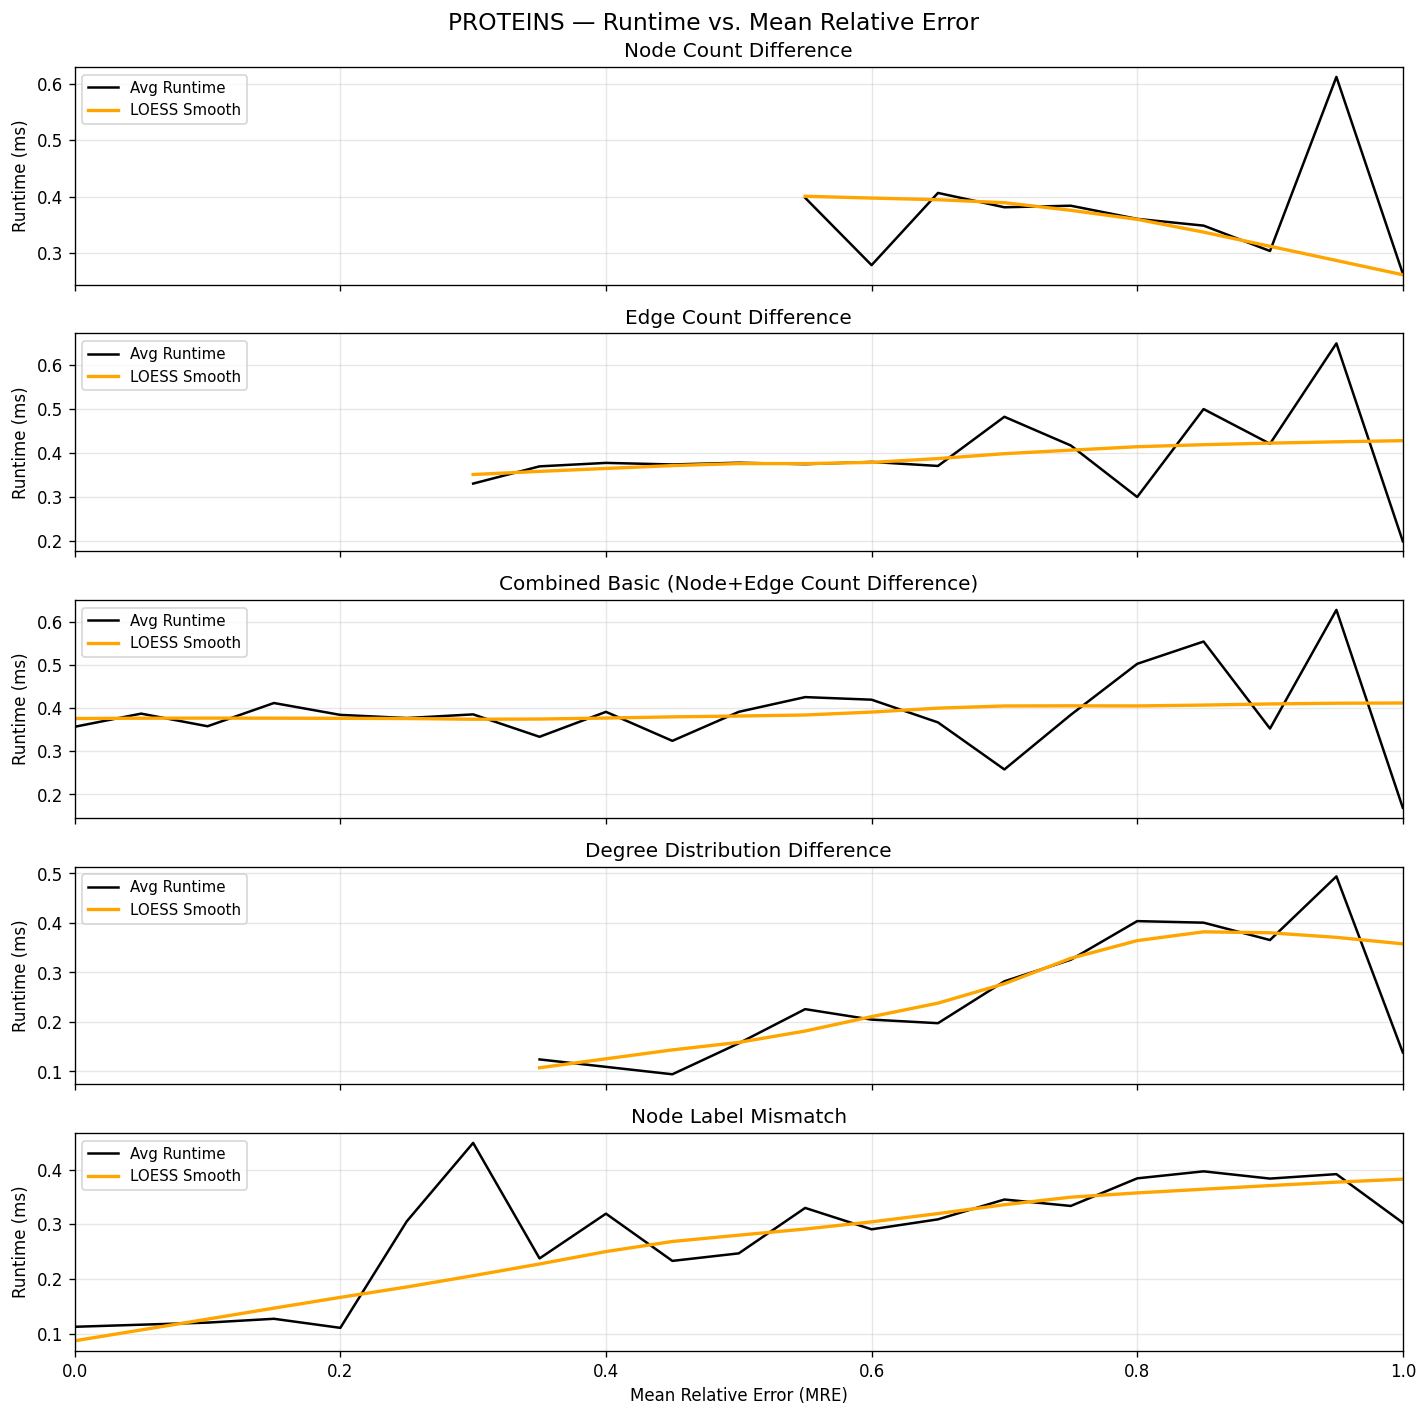

In [12]:
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

def plot_runtime_vs_mre(dataset_name):
    """
    Plots the runtime (in ms) vs. mean relative error (MRE) for each heuristic.
    """
    # Get data for the specified dataset
    dataset_data = merged[merged["Dataset"] == dataset_name]

    # Filter out Edge Overlap Difference heuristic
    heuristics = [h for h in ordered_heuristics if h != "Edge Overlap Difference"]

    fig, axes = plt.subplots(nrows=len(heuristics), figsize=(12, 12), sharex=True, dpi=120)

    for i, heuristic in enumerate(heuristics):
        heur_data = dataset_data[dataset_data["Heuristic"] == heuristic]

        # Drop rows with missing data
        heur_data = heur_data.dropna(subset=["Runtime", "Lower Bound", "min_ged"])

        if heur_data.empty:
            axes[i].text(0.5, 0.5, f"No data for {heuristic}",
                       ha='center', va='center', transform=axes[i].transAxes)
            continue

        # Calculate relative error for each graph pair
        heur_data['relative_error'] = abs(heur_data['Lower Bound'] - heur_data['min_ged']) / heur_data['min_ged']

        # Convert runtime to milliseconds (assuming it's in seconds)
        heur_data['runtime_ms'] = heur_data['Runtime'] * 1000

        # Round MRE to create reasonable groups (e.g., 0.05 increments)
        heur_data['mre_rounded'] = (heur_data['relative_error'] * 20).round() / 20

        # Group by rounded MRE and calculate mean runtime
        grouped = heur_data.groupby('mre_rounded')['runtime_ms'].mean().reset_index()
        grouped = grouped.sort_values('mre_rounded')

        # Plot only the line without markers
        axes[i].plot(
            grouped['mre_rounded'],
            grouped['runtime_ms'],
            '-',
            color='black',
            linewidth=1.5,
            label='Avg Runtime'
        )

        # Add LOESS smooth curve if enough data points
        if len(grouped) > 3:
            try:
                x = grouped['mre_rounded'].values
                y = grouped['runtime_ms'].values

                loess_smoothed = lowess(y, x, frac=0.6)

                axes[i].plot(
                    loess_smoothed[:, 0],
                    loess_smoothed[:, 1],
                    color='orange',
                    linewidth=2,
                    label='LOESS Smooth'
                )
            except Exception as e:
                print(f"LOESS error for {heuristic}: {e}")

        # Format plot
        axes[i].set_title(f"{heuristic}", fontsize=12)
        axes[i].set_ylabel("Runtime (ms)", fontsize=10)
        axes[i].grid(True, alpha=0.3)
        axes[i].set_xlim(0, min(2.0, grouped['mre_rounded'].max() * 1.1) if not grouped.empty else 2.0)
        axes[i].legend(loc="best", fontsize=9)

    # Shared x-axis label
    axes[-1].set_xlabel("Mean Relative Error (MRE)", fontsize=10)
    # Set the x-axis limit to 1
    axes[-1].set_xlim(0, 1)
    fig.suptitle(f"{dataset_name} — Runtime vs. Mean Relative Error", fontsize=14)
    plt.tight_layout()
    plt.show()

# First merge the lower bound data with exact GED and add runtime information
# Make sure to include "Runtime" column in your merge
merged = pd.merge(
    df[df["Dataset"].isin(datasets)],
    exact_df[["Dataset", "graph_id1", "graph_id2", "min_ged", "runtime"]].rename(columns={"runtime": "Runtime"}),
    on=["Dataset", "graph_id1", "graph_id2"],
    how="inner"
)

# Filter out invalid values
merged = merged[(merged["Lower Bound"].notna()) & (merged["min_ged"].notna()) & (merged["min_ged"] > 0)]

# If the Runtime column doesn't exist, you can add dummy values for demonstration
if "Runtime" not in merged.columns:
    # Generate random runtime values between 0.001 and 0.1 seconds
    merged["Runtime"] = np.random.uniform(0.001, 0.1, size=len(merged))

# Plot the runtime vs MRE for AIDS dataset
plot_runtime_vs_mre("PROTEINS")